In [ ]:
from utils import *
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import warnings 

%load_ext autoreload 
%autoreload 2

# NOTE: The n_bottom_2024 transcriptome library is a bit on the small size. 

In [2]:
mp_genome_ids = ['mp_15', 'mp_1', 'mp_5', 'mp_12', 'mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20'] # From sandbox-1.ipynb
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in pd.read_csv('ref_genes.csv', comment='#').groupby('genome_id')}

In [273]:
# First question to address is which genes are the most highly expressed in each strain and sample?
metat_df = metat_load(data_dir='../data/metat/').rename(columns={'length':'genome_size'})
metat_df['sample_id'] = metat_df.sample_id.str.replace('_metat', '')
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)

agg_funcs = {'read_count':'sum', 'genome_size':'sum', 'library_size':'first', 'year':'first', 'location':'first', 'reactor':'first', 'detected':'mean'}
metat_agg_df = metat_df.groupby(['genome_id', 'sample_id']).agg(agg_funcs).reset_index()
metat_agg_df['rpkm'] = metat_agg_df.read_count / (metat_agg_df.genome_size / 1e3) / (metat_agg_df.library_size / 1e6)
metat_agg_df['sample_id'] = metat_agg_df.sample_id.str.replace('_metat', '')

interproscan_df = load_interproscan()
interproscan_df = interproscan_df[interproscan_df.e_value < 1e-5].copy()
interproscan_df['gene_id'] = interproscan_df['id']

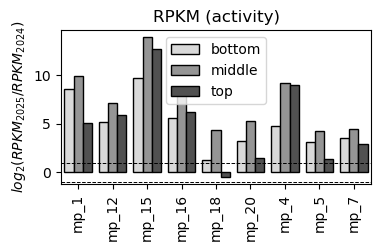

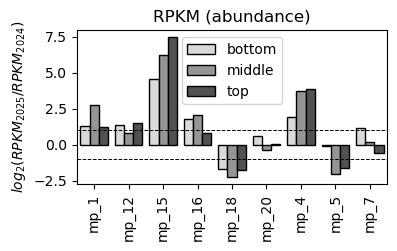

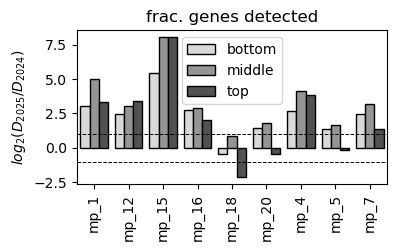

In [220]:
# Because of the compositional nature of the data, it is hard to distinguish between true zeros and sampling zeros, particularly
# in lowly-expressed genes. 

metric = 'RPKM'
metric = 'D'

def plot_fold_change(figure_df:pd.DataFrame, metric=metric, title='activity'):

    fig, ax = plt.subplots(figsize=(4, 2)) 

    figure_df = figure_df[(figure_df.reactor == 'n') & figure_df.genome_id.isin(mp_genome_ids)].copy()
    figure_df = figure_df.rename(columns={'rpkm':'RPKM', 'detected':'D'})
    figure_df = figure_df.pivot(index=['genome_id', 'location'], values=metric, columns='year')
    figure_df = figure_df.reset_index()
    figure_df[f'log2_{metric}_ratio'] = np.log2(figure_df['2025'] / figure_df['2024'])
    figure_df[f'log10_{metric}_2024'] = np.log10(figure_df['2024'])
    figure_df[f'log10_{metric}_2025'] = np.log10(figure_df['2025'])

    sns.barplot(figure_df, y=f'log2_{metric}_ratio', x='genome_id', hue='location', palette='Grays', ax=ax, edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('$log_2(' + metric + '_{2025} / ' + metric + '_{2024})$')
    ax.set_xlabel('')
    ax.get_legend().set_title('')
    ax.axhline(1, ls='--', color='black', lw=0.7)
    ax.axhline(-1, ls='--', color='black', lw=0.7)
    ax.set_title(title)
    plt.show()
    return figure_df

plot_fold_change(metat_agg_df, title='RPKM (activity)', metric='RPKM')
plot_fold_change(coverm_df, title='RPKM (abundance)', metric='RPKM')
figure_df = plot_fold_change(metat_agg_df, metric='D', title='frac. genes detected')

# Focusing on mp_18: With filtering approaches (1) and (2), many housekeeping genes (e.g. Rbp11, Rbp2) seem to be up-regulated 
# substantially (top 5th percentile), which indicates to me that the CLR assumption may not hold (geometric mean is either too low in 
# 2025 or too high in 2024). This could be biological, if overall baseline expression is higher in 2025. This is supported by the observation that,
# even though RPKM increases, the fraction of the genome detected decreases. Conclusion is that CLR normalization will not work for mp_18. 



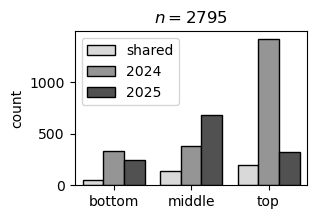

In [262]:
def plot_detected_genes(metat_df, genome_id:str='mp_18'):

    fig, ax = plt.subplots(figsize=(3, 2)) 

    get_n_shared_genes = lambda df : len(np.intersect1d(df[(df.year == '2024') & (df.read_count > 0)].gene_id.unique(), df[(df.year == '2025') & (df.read_count > 0)].gene_id.unique()))

    metat_df = metat_df[(metat_df.reactor == 'n') & (metat_df.genome_id == genome_id)].copy()

    figure_df = list()
    for location, df in metat_df.groupby('location'):
        figure_df.append({'category':'shared', 'n':get_n_shared_genes(df), 'location':location})
        figure_df.append({'category':'2024', 'n':((df.year == '2024') & (df.read_count > 0)).sum(), 'location':location})
        figure_df.append({'category':'2025', 'n':((df.year == '2025') & (df.read_count > 0)).sum(), 'location':location})
    figure_df = pd.DataFrame(figure_df)
    n_total = metat_df.gene_id.nunique()

    sns.barplot(figure_df, y='n', x='location', hue='category', palette='Grays', ax=ax, edgecolor='black')
    ax.set_xlabel('')
    ax.set_ylabel('count')
    ax.get_legend().set_title('')
    ax.set_title(f'$n={n_total}$')
    plt.show()

plot_detected_genes(metat_df)

In [346]:
def plot_gene_presence(figure_df:pd.DataFrame, title='ribosomal proteins', drop_empty:bool=True, figsize=(3, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    figure_df = figure_df[figure_df.reactor == 'n'].copy()
    figure_df = figure_df.pivot(columns='sample_id', values='read_count', index='annotation')
    figure_df.columns = figure_df.columns.str.replace('_metat', '')
    figure_df = figure_df.fillna(0).astype(int)
    if drop_empty:
        print(f'plot_gene_presence: Dropping {(figure_df.sum(axis=1).values.ravel() > 0).sum()} genes with no presence in any sample.')
        figure_df = figure_df[figure_df.sum(axis=1).values.ravel() > 0].copy()

    sns.heatmap(figure_df, annot=True, fmt='d', cmap='Grays', lw=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
    plt.show()

In [358]:
rnap_gene_ids = interproscan_df[interproscan_df.interpro_description.str.contains('RNA polymerase') & (interproscan_df.genome_id == 'mp_18')].gene_id.unique()

annotations = dict()
annotations['mp_18.1_1024'] = 'DNA/RNA polymerase (1)'
annotations['mp_18.1_1331'] = 'Rpb3'
annotations['mp_18.1_1469'] = 'Rbp10'
annotations['mp_18.1_1470'] = 'Rbp6'
annotations['mp_18.1_1506'] = 'Rpb1 beta-prime'
annotations['mp_18.1_1507'] = 'Rpb1 alpha'
annotations['mp_18.1_1508'] = 'Rpb2 (1)'
annotations['mp_18.1_1509'] = 'Rbp2 (2)'
annotations['mp_18.1_1510'] = 'Rbp5'
annotations['mp_18.1_1766'] = 'Rbp4'
annotations['mp_18.1_211'] = 'Rbp11'
annotations['mp_18.1_220'] = 'transcription elongation factor Spt4'
annotations['mp_18.1_221'] = 'Rbp7'
annotations['mp_18.1_2392'] = 'DNA/RNA polymerase (2)'
annotations['mp_18.1_2763'] = 'transcription factor S'
annotations['mp_18.1_420'] = 'DNA/RNA polymerase (3)'
annotations['mp_18.1_897'] = 'DNA/RNA polymerase (4)'

mp_18_rnap_df = metat_df[metat_df.gene_id.isin(rnap_gene_ids)].copy()
mp_18_rnap_df['annotation'] = mp_18_rnap_df.gene_id.map(annotations)

# plot_gene_presence(mp_18_rnap_df, title='RNA polymerase') # Get those which are expressed somewhere. 
rnap_gene_ids = ['mp_18.1_1509', 'mp_18.1_1508', 'mp_18.1_1506', 'mp_18.1_1506', 'mp_18.1_1331', 'mp_18.1_1469', 'mp_18.1_211'] #, 'mp_18.1_420', 'mp_18.1_1024', 'mp_18.1_897']


In [326]:
# First want to identify how many ribosomal proteins are annotated in mp_18. This should be up on ggKbase. 
def load_ggkbase_gene_table(path:str, genome_id='mp_18'):
    # TODO: Will need to fix this function if more than one contig is present. 
    df = pd.read_csv(path, sep='\t', usecols=[0, 1, 2], names=['annotation', 'contig', 'features'], skiprows=1)

    df_ = list() # Kind of annoying but some of the genes are listed on the same line. 
    for row in df.itertuples():
        gene_ids = [gene_id.strip().split('_')[-1] for gene_id in row.features.split(',')]
        df_ += [{'gene_id':f'{genome_id}.1_{id_}', 'annotation':f'{row.annotation} ({i + 1})'} for i, id_ in enumerate(gene_ids)]
    df = pd.DataFrame(df_)
    df = df[['gene_id', 'annotation']].copy()
    return df 

mp_18_rp_df = load_ggkbase_gene_table('mp_18_ribosomal_proteins.txt')
mp_18_rp_df = mp_18_rp_df.merge(metat_df, on='gene_id', how='left')

mp_18_scg_df = load_ggkbase_gene_table('mp_18_archaeal_scg.txt')
# mp_18_scg_df = mp_18_scg_df.merge(metat_df, on='gene_id', how='left')

# plot_gene_presence(mp_18_scg_df)
# plot_gene_presence(mp_18_rp_df)


plot_gene_presence: Dropping 12 genes with no presence in any sample.


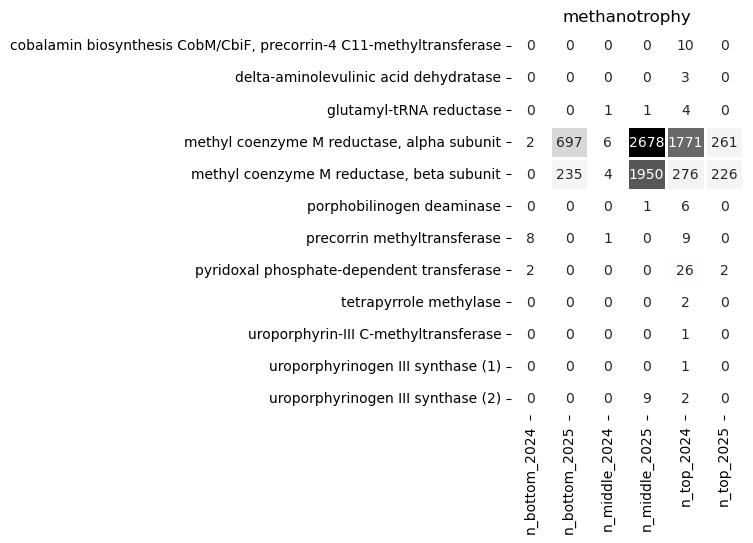

In [336]:
methanotrophy_accessions = pd.read_csv(f'../data/interpro_methanotrophy.csv', usecols=['accession']).accession.values 
methanotrophy_gene_ids = interproscan_df[interproscan_df.interpro_accession.isin(methanotrophy_accessions) & (interproscan_df.genome_id == 'mp_18')].gene_id.unique()

annotations = dict()
annotations['mp_18.1_1228'] = 'tetrapyrrole methylase'
annotations['mp_18.1_1407'] = 'pyridoxal phosphate-dependent transferase'
annotations['mp_18.1_1408'] = 'porphobilinogen deaminase'
annotations['mp_18.1_1409'] = 'uroporphyrin-III C-methyltransferase'
annotations['mp_18.1_1410'] = 'uroporphyrinogen III synthase (1)'
annotations['mp_18.1_1478'] = 'diphthine synthase'
annotations['mp_18.1_1649'] = 'precorrin methyltransferase'
annotations['mp_18.1_1651'] = 'cobalamin biosynthesis CobM/CbiF, precorrin-4 C11-methyltransferase'
annotations['mp_18.1_2107'] = 'delta-aminolevulinic acid dehydratase'
annotations['mp_18.1_2147'] = 'methyl coenzyme M reductase, alpha subunit'
annotations['mp_18.1_2150'] = 'methyl coenzyme M reductase, beta subunit'
annotations['mp_18.1_736'] = 'glutamyl-tRNA reductase'
annotations['mp_18.1_977'] = 'uroporphyrinogen III synthase (2)'

mp_18_mcr_df = metat_df[metat_df.gene_id.isin(methanotrophy_gene_ids)].copy()
mp_18_mcr_df['annotation'] = mp_18_mcr_df.gene_id.map(annotations)

plot_gene_presence(mp_18_mcr_df, title='methanotrophy')

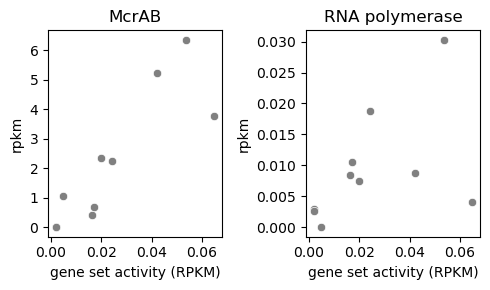

In [360]:
mcr_gene_ids = ['mp_18.1_2150', 'mp_18.1_2147']

def plot_rpkm_correlation(gene_ids:list, genome_id:str='mp_18', ax=None, title:str=None):
    figure_df = metat_df[metat_df.gene_id.isin(gene_ids)].copy()
    figure_df = figure_df.groupby('sample_id').agg({'read_count':'sum', 'genome_size':'sum', 'library_size':'first'}).reset_index()
    figure_df['sample_rpkm'] = figure_df.sample_id.map(metat_agg_df[metat_agg_df.genome_id == genome_id].set_index('sample_id').rpkm)
    figure_df['rpkm'] = figure_df.read_count / (figure_df.genome_size / 1e3) / (figure_df.library_size / 1e6)
    sns.scatterplot(figure_df, x='sample_rpkm', y='rpkm', ax=ax, color='gray')
    ax.set_xlabel('sample activity (RPKM)')
    ax.set_xlabel('gene set activity (RPKM)')
    ax.set_title(title)
    return figure_df

fig, axes = plt.subplots(figsize=(5, 3), ncols=2)
plot_rpkm_correlation(mcr_gene_ids, ax=axes[0], title='McrAB')
plot_rpkm_correlation(rnap_gene_ids, ax=axes[1], title='RNA polymerase')
fig.tight_layout()
plt.show()

In [ ]:


mp_18_ref_gene_ids_v1 = dict()
mp_18_ref_gene_ids_v1['top'] = ['mp_18.1_1923', 'mp_18.1_1122', 'mp_18.1_1069', 'mp_18.1_1123', 'mp_18.1_1331', 'mp_18.1_1508', 'mp_18.1_237', 'mp_18.1_239', 'mp_18.1_24', 'mp_18.1_246', 'mp_18.1_616', 'mp_18.1_2027']
mp_18_ref_gene_ids_v1['middle'] = ['mp_18.1_1885', 'mp_18.1_888', 'mp_18.1_227', 'mp_18.1_1122', 'mp_18.1_1885', 'mp_18.1_1012', 'mp_18.1_1039', 'mp_18.1_1123', 'mp_18.1_1331', 'mp_18.1_1507', 'mp_18.1_1508', 'mp_18.1_1801', 'mp_18.1_2616', 'mp_18.1_2664', 'mp_18.1_2676']
mp_18_ref_gene_ids_v1['bottom'] = ['mp_18.1_1123', 'mp_18.1_1526', 'mp_18.1_1923', 'mp_18.1_2616', 'mp_18.1_396', 'mp_18.1_1615']

mp_18_ref_gene_ids_v2 = dict()
mp_18_ref_gene_ids_v2['top'] = ['mp_18.1_237', 'mp_18.1_239', 'mp_18.1_24', 'mp_18.1_246', 'mp_18.1_616', 'mp_18.1_2027']
mp_18_ref_gene_ids_v2['middle'] = []
mp_18_ref_gene_ids_v2['bottom'] = []




In [ ]:
# for gene_id in mp_18_ref_gene_ids_v1['middle']:
#     annotations_df = interproscan_df[interproscan_df.gene_id == gene_id].copy()
#     annotations_df = annotations_df.drop_duplicates('interpro_accession')
#     for row in annotations_df.itertuples():
#         print(gene_id, row.interpro_description)
#     print()

annotations = dict()
annotations['mp_18.1_1123'] = 'translation elongation factor EF2' # Remove.
annotations['mp_18.1_1331'] = 'RNA polymerase Rbp11' # Remove.
annotations['mp_18.1_1507'] = 'RNA polymerase Rbp1'
annotations['mp_18.1_1502'] = 'ribosomal protein uS7'
annotations['mp_18.1_1122'] = 'translation elongation factor EF1-alpha' # Remove
annotations['mp_18.1_1923'] = 'ribosomal protein uL10' # Apparently can be variable.
annotations['mp_18.1_616'] = 'ribosomal protein eS1'
annotations['mp_18.1_239'] = 'ribosomal protein eS4'
annotations['mp_18.1_246'] = 'ribosomal protein uL18'
annotations['mp_18.1_24'] = 'ribosomal protein eL31'
annotations['mp_18.1_237'] = 'ribosomal protein uL14'
annotations['mp_18.1_1502'] = 'ribosomal protein uS7'
annotations['mp_18.1_1526'] = 'ribosomal protein uL16'
annotations['mp_18.1_1508'] = 'RNA polymerase Rbp2' # Remove?
annotations['mp_18.1_2027'] = 'ATP synthase subunit beta'
annotations['mp_18.1_1039'] = 'tRNA pseudouridylate synthase B'
annotations['mp_18.1_543'] = 'tryptophan synthase'
annotations['mp_18.1_2616'] = 'DNA topoisomerase'
annotations['mp_18.1_396'] = 'phosphoribosylglycinamide synthetase'
annotations['mp_18.1_1012'] = 'tRNA ribosyltransferase' # Remove.
annotations['mp_18.1_1069'] = 'translation initiation factor IF2' # Remove.
annotations['mp_18.1_227'] = 'ribosomal protein L3'
annotations['mp_18.1_1885'] = 'ribosomal protein eL43'
annotations['mp_18.1_1801'] = 'translation release factor pelota'
annotations['mp_18.1_1385'] = 'ribosomal protein uS5' # Also has annotations for Lon Protease.
annotations['mp_18.1_2674'] = 'ribosomal protein uS5' # Also has annotations for beta-ribofuranosylphenol 5'-phosphate synthase.
annotations['mp_18.1_2664'] = 'ribosomal protein uS5' # Annotations are unclear.
annotations['mp_18.1_2676'] = 'peptide chain release factor eRF1/aRF1'
annotations['mp_18.1_1772'] = 'HAD-like ATPase'
annotations['mp_18.1_528'] = 'chaperone dnaK'
annotations['mp_18.1_529'] = 'chaperone dnaJ'
annotations['mp_18.1_2713'] = 'proteasome regulatory ATPase'
annotations['mp_18.1_2333'] = 'proteasome regulatory ATPase'

# annotations['mp_18.1_1615'] = 'tryptophan synthase' # I think this one is actually Serine/Threonine Dehydratase



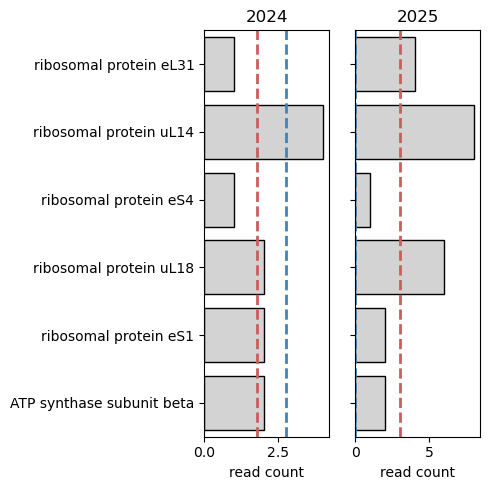

In [192]:
# Still having a problem where the reference genes are up-regulated which are in the ALR reference set. 
# This means that they are not centered around the geometric mean, which is weird. 

def plot_alr_reference_set(metat_df, ref_gene_ids:list, location:str='top', genome_id='mp_18', annotations=annotations):

    fig, axes = plt.subplots(figsize=(5, 5), sharey=True, ncols=2)

    mask = (metat_df.location == location) & (metat_df.genome_id == genome_id) & (metat_df.reactor == 'n')
    figure_df = metat_df[mask].copy()
    figure_df = metat_filter(figure_df, min_samples=1, threshold=1)
    figure_df = metat_add_pseudocounts(figure_df, method='mzr')

    for ax, year in zip(axes, ['2024', '2025']):
        ax_df = figure_df[figure_df.year == year].copy()
        clr_mean = gmean(ax_df.read_count)
        ax_df = ax_df[ax_df.gene_id.isin(ref_gene_ids)].copy()
        alr_mean = gmean(ax_df.read_count)

        sns.barplot(ax_df, y='gene_id', x='read_count', ax=ax, color='lightgray', legend=False, edgecolor='black')
        ax.axvline(alr_mean, ls='--', color='indianred', lw=2)
        ax.axvline(clr_mean, ls='--', color='steelblue', lw=2)

        ax.set_title(year)
        ax.set_xlabel('read count')

        if year == '2024':
            ax.set_yticks(ax.get_yticks(), [annotations.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()])
            ax.set_ylabel('')
    
    fig.tight_layout()
    plt.show()

# plot_alr_reference_set(metat_df, mp_18_ref_gene_ids_v2['bottom'], location='bottom')
plot_alr_reference_set(metat_df, mp_18_ref_gene_ids_v2['top'], location='top')



get_diff: 12 out of 12 reference genes retained after filtering.
get_diff: Retained 1545 genes for mp_18.
get_diff: 14 out of 14 reference genes retained after filtering.
get_diff: Retained 923 genes for mp_18.
get_diff: 5 out of 5 reference genes retained after filtering.
get_diff: Retained 526 genes for mp_18.


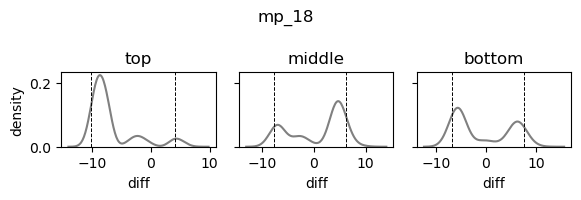

In [ ]:
def get_diff(metat_df, location:str='bottom', reactor:str='n', genome_id=None, normalization='clr', ref_gene_ids=[]):

    mask = ((metat_df.genome_id == genome_id) & (metat_df.reactor == reactor) & (metat_df.location == location))
    metat_df = metat_df[mask].copy()

    # metat_df = pd.concat([metat_filter(metat_df, threshold=20, min_samples=1), metat_filter(metat_df, threshold=1, min_samples=2)])
    metat_df = metat_filter(metat_df, threshold=1, min_samples=1)
    if normalization == 'alr':
        print(f'get_diff: {np.isin(ref_gene_ids, metat_df.gene_id.unique()).sum()} out of {len(ref_gene_ids)} reference genes retained after filtering.')
    # metat_df = metat_filter(metat_df, threshold=min_rpkm, min_samples=1)
    metat_df = metat_df.drop_duplicates(['gene_id', 'year'])
    print(f'get_diff: Retained {metat_df.gene_id.nunique()} genes for {genome_id}.')
    metat_df = metat_normalize(metat_df, method=normalization, ref_gene_ids={genome_id:ref_gene_ids}, add_pseudocount='mzr')

    diff_df = dict()
    diff_df = {year:df.set_index('gene_id').sort_index() for year, df in metat_df.groupby('year')}

    diff_df = diff_df['2025'][['read_count_normalized']] - diff_df['2024'][['read_count_normalized']]
    diff_df = diff_df.reset_index().rename(columns={'read_count_normalized':'diff'})
    diff_df['genome_id'] = genome_id
    diff_df['location'] = location
    return diff_df

genome_id = 'mp_18'
quantile = 0.05
locations = ['top', 'middle', 'bottom']

fig, axes = plt.subplots(figsize=(2 * len(locations), 2), ncols=len(locations), sharey=True)

df = list()

for ax, location in zip(axes, locations):
    figure_df = get_diff(metat_df, genome_id=genome_id, location=location, normalization='alr', ref_gene_ids=mp_18_ref_gene_ids_v1[location])
    # figure_df = get_diff(metat_df, genome_id=genome_id, location=location)
    up_threshold = np.quantile(figure_df['diff'].values, 1 - quantile).item()
    down_threshold = np.quantile(figure_df['diff'].values, quantile).item()

    sns.kdeplot(figure_df, x='diff', common_norm=False, color='gray', ax=ax)
    ax.axvline(up_threshold, ls='--', color='black', lw=0.7)
    ax.axvline(down_threshold, ls='--', color='black', lw=0.7)
    # ax.axvline(figure_df['diff'].median(), ls='-', color='black', lw=1)
    ax.set_ylabel('density')
    ax.set_title(location)
    
    df.append(figure_df[(figure_df['diff'] > up_threshold)].assign(regulation='up').copy())
    df.append(figure_df[(figure_df['diff'] < down_threshold)].assign(regulation='down').copy())

df = pd.concat(df)

fig.suptitle(genome_id)
fig.tight_layout()
plt.show()

In [70]:
for gene_id, df_ in df[(df.regulation == 'down') & (df.location == 'top')].merge(interproscan_df, on='gene_id', how='left').groupby('gene_id'):
    for row in df_[df_.interpro_accession != '-'].drop_duplicates(['interpro_accession', 'location']).itertuples():
        print(gene_id, row.interpro_accession, row.interpro_description)
    print()

# Two filtering approaches:
# (1) threshold=1, min_samples=1, Results in a unimodal distribution of differential expression values centered around 0, which indicates that
#   for the majority of genes detected in both samples, the difference in relative expression is negligible.
# (2) threshold~10, min_samples=1





mp_18.1_1002 IPR013154 Alcohol dehydrogenase-like, N-terminal
mp_18.1_1002 IPR036291 NAD(P)-binding domain superfamily
mp_18.1_1002 IPR011032 GroES-like superfamily
mp_18.1_1002 IPR020843 Polyketide synthase, enoylreductase domain
mp_18.1_1002 IPR050700 YIM1 and Zinc-containing Alcohol Dehydrogenase Families

mp_18.1_101 IPR001750 NADH:quinone oxidoreductase/Mrp antiporter, membrane subunit
mp_18.1_101 IPR052175 Complex I-like Hydrogenase Component
mp_18.1_101 IPR003918 NADH:ubiquinone oxidoreductase

mp_18.1_1018 IPR036485 Glutamate synthase, alpha subunit, C-terminal domain superfamily

mp_18.1_1023 IPR036909 Cytochrome c-like domain superfamily
mp_18.1_1023 IPR051395 Cytochrome c-dependent Peroxidase and MauG

mp_18.1_1033 IPR036866 Ribonuclease Z/Hydroxyacylglutathione hydrolase-like
mp_18.1_1033 IPR036873 Rhodanese-like domain superfamily
mp_18.1_1033 IPR001763 Rhodanese-like domain
mp_18.1_1033 IPR001279 Metallo-beta-lactamase
mp_18.1_1033 IPR051682 Mitochondrial Persulfide Dioxy

In [8]:
# Want to plot the distribution of normalized ALR values... 

# fig, ax = plt.subplots(figsize=(5, 5))
# sample_id = 'n_bottom_2025_metat'
# figure_df = metat_df[metat_df.sample_id == sample_id].copy()
# sns.kdeplot(figure_df, hue='genome_id', x='read_count_normalized', common_norm=False, palette='Grays')
# ax.set_title(sample_id)

In [9]:
# First want to look at the metabolic potential of the genomes. What genes are present?
# Relevant metabolism things: (https://www.cell.com/trends/microbiology/fulltext/S0966-842X(25)00031-9)
# (1) Iron reduction (https://pmc.ncbi.nlm.nih.gov/articles/PMC7005843/)
# (2) Nitrate reduction
# (3) Humic acid reduction 
# (4) Methanotrophy 
# Denitrification (nitrate to nitrite) https://www.kegg.jp/module/M00529
# Might also be worth looking into genes for stress response. 



In [10]:

# Using the abundance data... In cases where RPKM is reasonably-high across years, it seems reasonable to assume that any zeros
# are true zeros, not sampling zeros. 
# print('Num. comparisons:', len(figure_df))
# min_rpkm = 10
# print(f'Num. comparisons with both RPKM > {min_rpkm}:', ((figure_df['2025'] > min_rpkm) & (figure_df['2024'] > min_rpkm)).sum())
# print()
# for row in figure_df[(figure_df['2025'] > min_rpkm) & (figure_df['2024'] > min_rpkm)].itertuples():
#     print(row.genome_id, row.location)

In [194]:
# For ALR reference genes, we want genes coupled to cell existence, but not things like growth rate, stress, etc. 
# https://www.frontiersin.org/journals/microbiology/articles/10.3389/fmicb.2019.02896/full uses infB, atpB, etc.
# https://omim.org/entry/138440 
# Seems like some transporter ATPases can be considered housekeeping genes https://pmc.ncbi.nlm.nih.gov/articles/PMC4513125/ 

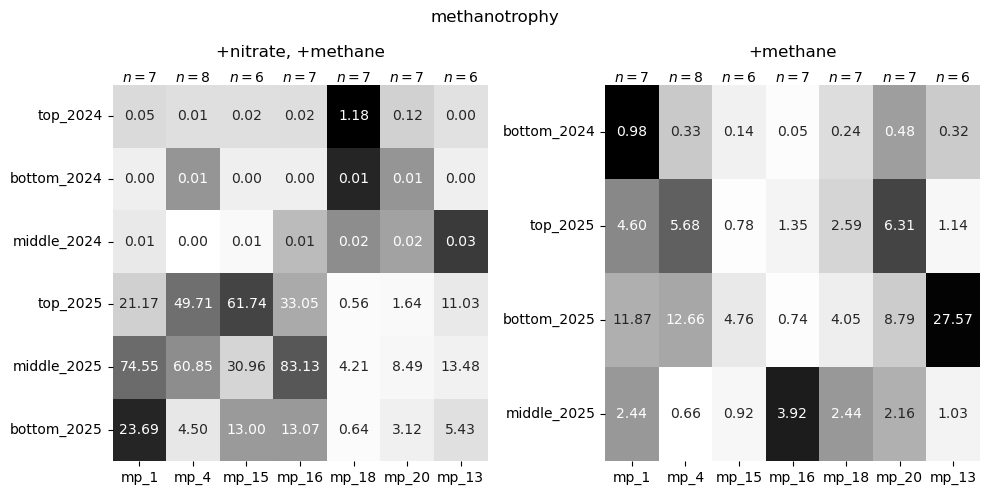

In [ ]:
# Heatmap figure with strain on the x-axis and sample on the y-axis. One figure for each type of metabolism, 
# and each square is the proportion of genes related to that metabolism expressed in that particular sample
def figure(metat_df:pd.DataFrame, genes=None, title:str='', cpm:bool=False, genome_ids=mp_genome_ids):
    
    fig, (n_ax, ck_ax) = plt.subplots(figsize=(10, 5), ncols=2)

    metat_df = metat_df.copy()
    metat_df = metat_df[metat_df.genome_id.isin(genome_ids)].copy()
    metat_df['location'] = pd.Categorical(metat_df.location, categories=['bottom', 'middle', 'top'])
    metat_df['genome_id'] = pd.Categorical(metat_df.genome_id, categories=genome_ids)
    metat_df = metat_df.sort_values(['year', 'genome_id'])
    metat_df = metat_df[metat_df.gene_id.isin(genes)].copy()

    if cpm:
        metat_df['read_count'] = metat_df.read_count / (metat_df.library_size / 1e6) # Per million reads.
    fmt = '.2f' if cpm else 'd'

    for (reactor, df) in metat_df.groupby('reactor'): 
        ax = n_ax if (reactor == 'n') else ck_ax
        df['sample_id'] = df.sample_id.str.replace(f'{reactor}_', '')
        sample_ids = df.sample_id.unique()
        figure_df = pd.DataFrame(index=sample_ids, columns=genome_ids)

        totals = list()
        for genome_id, df_ in df.groupby('genome_id', observed=True):
            totals.append(df_.gene_id.nunique()) # Total number of genes present associated with the metabolism. 
            figure_df[genome_id] = df_[df_.read_count > 0].groupby('sample_id').size()
            figure_df[genome_id] = df_[df_.read_count > 0].groupby('sample_id').read_count.mean() 
            # get_gmean = lambda df : gmean(df.read_count.values)
            # figure_df[genome_id] = df[df.read_count_original > 0].groupby('sample_id').read_count_normalized.max() 

        # figure_df = figure_df.sort_index().apply(pd.to_numeric, errors='coerce').fillna(0)# .astype(int)
        figure_df = figure_df.apply(pd.to_numeric, errors='coerce').fillna(0)# .astype(int)
        sns.heatmap((figure_df - figure_df.mean(axis=1).values[:, None]) / figure_df.std(axis=1).values[:, None], cmap='Grays', annot=figure_df, cbar=False, fmt=fmt, ax=ax)
        
        for x, n in zip(ax.get_xticks(), totals):
            ax.text(x, ax.get_ylim()[-1], '$n=$' + str(n), va='bottom', ha='center')
        ax.set_title('+nitrate, +methane' if (reactor == 'n') else '+methane', pad=20)
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
        
    fig.suptitle(title)
    fig.tight_layout()

    return figure_df

mp_genome_ids = ['mp_1', 'mp_4', 'mp_15', 'mp_16', 'mp_18', 'mp_20', 'mp_13']

# figure_df = figure(metat_df, genes=genes['iron_reduction_pilus'], title='iron reduction pilus', cpm=True)
# figure_df = figure(metat_df, genes=genes['nitrate_reduction'], title='nitrate reduction', cpm=True)
figure_df = figure(metat_df, genes=genes['methanotrophy'], title='methanotrophy', cpm=True, genome_ids=mp_genome_ids)
# The methanotrophy gene with crazy high expression in mp_2 is methyl-coenzyme reductase


In [ ]:
# Maybe the best way to think about expression is just as a presence or absence matrix, perhaps with a score corresponding to 
# the number of samples the gene is detected in. Probably should look at the ck and n reactors separately, not sure yet about
# 2024 versus 2025 in the n reactor, considering there are obvious metabolic changes.

id_cols = ['gene_id', 'genome_id']
df = metat_df.drop_duplicates(id_cols)[id_cols].copy()
# Maks sure to account for the pseudocount here, so make sure everything is > 1 not >= 1.
df = df.merge(metat_df.groupby(id_cols).apply(lambda df : ((df.reactor == 'ck') & (df.read_count > 1)).sum(), include_groups=False).reset_index(name='ck_sample_count'), on=id_cols)
df = df.merge(metat_df.groupby(id_cols).apply(lambda df : ((df.reactor == 'n') & (df.read_count > 1)).sum(), include_groups=False).reset_index(name='n_sample_count'), on=id_cols)
df['total'] = df.ck_sample_count + df.n_sample_count
df = df.sort_values('total')

interproscan_df = interproscan_df.drop_duplicates(['genome_id', 'gene_id']).rename(columns={'signature_description':'annotation'})
df = df.merge(interproscan_df[['genome_id', 'gene_id', 'annotation']], on=['genome_id', 'gene_id'], how='left')
df['annotation'] = df.annotation.fillna('-')
# df['annotation'] = [get_annotation(row.gene_id, row.genome_id) for row in tqdm(list(df.itertuples()), 'Collecting annotations from InterProScan data...')]

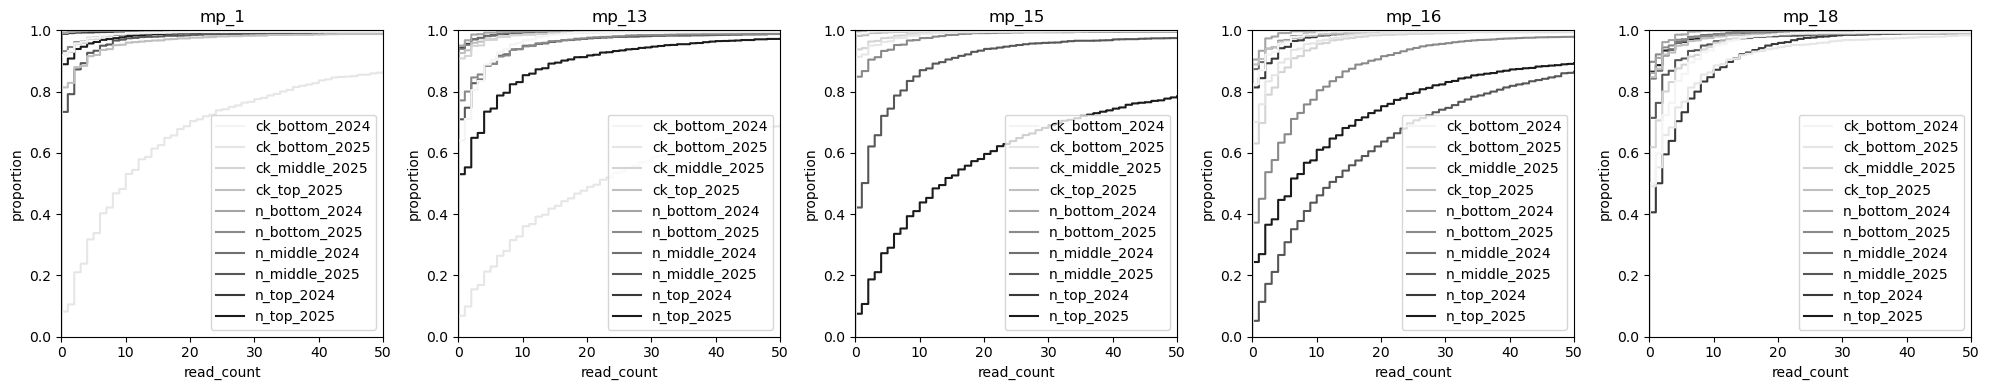

In [ ]:
# How best to normalize this data? Would be good to compare the relative expression levels across samples, so probably
# a good idea to use ALR normalization again, at least for Methanoperedens. Not sure what to do about the Borgs. 

def plot_read_counts(metat_df, ax=None, title:str='', legend:bool=True):
    figure_df = metat_df.sort_values('sample_id')
    figure_df = figure_df[figure_df.sample_id != 'n_bottom_2024_metat'].copy() # Sample with small library size.
    ax.set_title(title)
    sns.ecdfplot(figure_df, x='read_count', hue='sample_id', palette='Grays', ax=ax, legend=legend)
    ax.get_legend().set_title('')
    ax.set_xlim(xmin=0, xmax=50)
    ax.set_ylabel('proportion')

fig, axes = plt.subplots(figsize=(20, 4), ncols=5)

for ax, (genome_id, df) in zip(axes, list(metat_df[metat_df.genome_id.str.startswith('mp_')].groupby('genome_id'))):
    plot_read_counts(df, ax=ax, title=genome_id) #, legend=(genome_id == 'mp_5'))

fig.tight_layout()
plt.show()


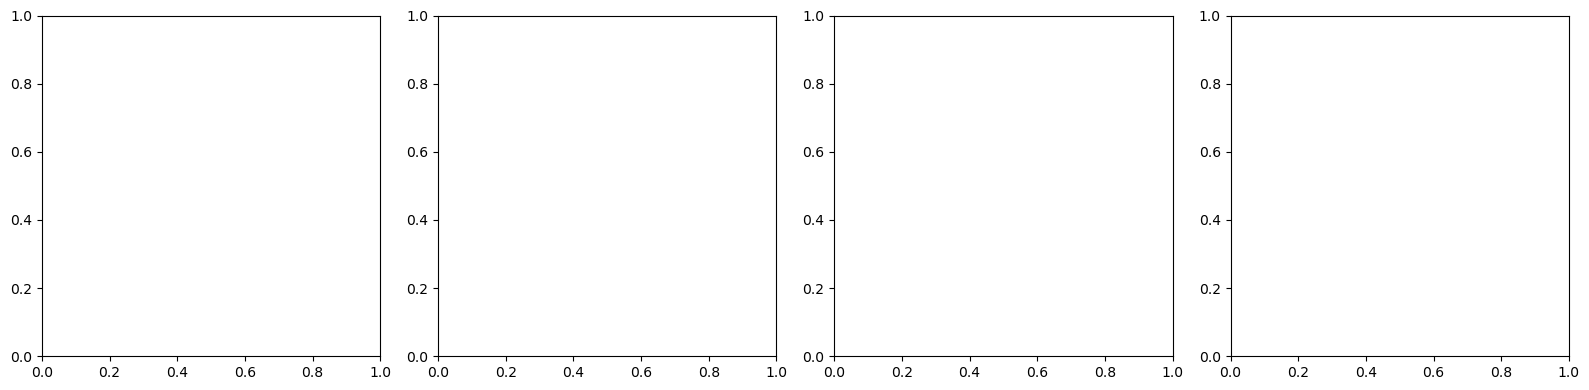

In [ ]:
# Also need to look at Borg expression to figure out how on earth to normalize it. 

fig, axes = plt.subplots(figsize=(16, 4), ncols=4)

genome_ids = ['black_borg', 'saturn_mini_borg_2', 'jupiter_mini_borg_3', 'linear_ece_19kb']
for ax, (genome_id, df) in zip(axes, list(metat_df[metat_df.genome_id.isin(genome_ids)].groupby('genome_id'))):
    plot_read_counts(df, ax=ax, title=genome_id) #, legend=(genome_id == 'mp_5'))

fig.tight_layout()
plt.show()


In [ ]:
# # Use HMMs from the FeGenie library to look for genes related to iron reduction. 
# hmmsearch_df = list()

# for path in glob.glob('../data/data/*.fa'):
#     genome_id = os.path.basename(path).replace('.fa', '')
#     output_path = f'../data/hmmsearch/{genome_id}-iron_reduction.tbl'
#     if not os.path.exists(output_path):
#         subprocess.run(f'hmmsearch --cpu 16 --tblout {output_path} ../data/hmms/iron_reduction.hmm {path} ', shell=True, check=True)
#     cols = ['query_id', 'query_description', 'target_id', 'target_decription', 'e_value', 'score', 'bias']
#     df = pd.read_csv(output_path, sep=r'\s+', comment='#', usecols=np.arange(len(cols)), names=cols)
#     if len(df) == 0:
#         continue
#     df['genome_id'] = genome_id
#     hmmsearch_df.append(df)

# hmmsearch_df = pd.concat(hmmsearch_df)
# hmmsearch_df = hmmsearch_df[is_mp(hmmsearch_df)].copy()
# hmmsearch_df = hmmsearch_df[hmmsearch_df.e_value < 1e-5].sort_values('e_value').copy()
# hmmsearch_df = hmmsearch_df.drop_duplicates(['genome_id', 'query_id'])

In [ ]:
# interproscan_df[interproscan_df.signature_description.str.contains('nitrate|nitrite', case=False) & (interproscan_df.genome_id == 'mp_2')].sort_values('gene_id')
# interproscan_df[interproscan_df.signature_description.str.contains('iron', case=False) & (interproscan_df.genome_id == 'mp_1')].sort_values('gene_id')

# # These three proteins seem to exist in an operon. 
# # DMSO/Nitrate reductase chaperone (PF02613)
# # Nitrate reductase beta subunit (PTHR43518)
# # MopB Nitrate-R-NarG-like domain-containing protein (cd02750)

# # mp_5 14_65 14_66 14_63
# # mp_1 24_19 24_21 24_22
# # mp_4 74_3 74_4
# # mp_2 none
# # mp_3 231_6

# # https://pmc.ncbi.nlm.nih.gov/articles/PMC9295563/

In [ ]:
# Reference set requirements (per organism):
# (1) At least one detected in each sample. 
# (2) Housekeeping genes. 

# genome_id = 'mp_15'
# metat_df_ = metat_df[metat_df.genome_id == genome_id].copy()
# metat_df_ = metat_df_[metat_df_.read_count > 0].copy()

# ref_genes_df = pd.DataFrame(metat_df_.groupby('gene_id').sample_id.nunique()).rename(columns={'sample_id':'n_samples'})
# ref_genes_df = ref_genes_df.sort_values('n_samples')
# ref_genes_df = ref_genes_df.reset_index()

# mask = (interproscan_df.interpro_accession != '-') & (~interproscan_df.duplicated(['gene_id', 'interpro_accession'], keep='first'))
# ref_genes_df = ref_genes_df.merge(interproscan_df[mask][['interpro_accession', 'interpro_description', 'gene_id']], on='gene_id', how='left')

# for gene_id, df in ref_genes_df[ref_genes_df.n_samples > 3].sort_values('n_samples').groupby('gene_id'):
#     for row in df.itertuples():
#         print(f'{genome_id},{row.gene_id},{row.n_samples},{row.interpro_accession},{row.interpro_description}')
#     print()

In [ ]:
# Want to normalize based on some set of housekeeping genes, possibly the ribosomal proteins. 

# pattern = r'[a-z]*((L\d+)|(S\d+)|(P\d+))'
# get_ribosomal_protein = lambda description : re.search(pattern, description).group(0) if (re.search(pattern, description)) else None

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     mask = interproscan_df.signature_description.str.contains('ribosomal', case=False) 
#     # mask = mask & (interproscan_df.signature_accession != '-')
#     mask = mask & (interproscan_df.interpro_accession != '-')
#     mask = mask & (interproscan_df.gene_id.str.contains('mp_'))
#     mask = mask & ~interproscan_df.interpro_accession.duplicated(keep='first')
#     mask = mask & interproscan_df.signature_description.str.contains(pattern, regex=True)

# ref_protein_accessions = interproscan_df[mask].interpro_accession.unique()

In [ ]:
# ref_metat_df = metat_df[is_mp(metat_df) & (metat_df.interpro_accession.isin(ref_protein_accessions))].copy()
# ref_metat_df = ref_metat_df.sort_values('e_value').drop_duplicates('gene_id')

# ref_gene_ids = list()
# for genome_id, df in ref_metat_df.groupby('genome_id'):
#     print(f'Num. ribosomal protein hits in {genome_id}:', len(df))
#     ref_gene_ids += df.gene_id.unique().tolist()
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in ref_metat_df[ref_metat_df.gene_id.isin(ref_gene_ids)].groupby('genome_id')}

# # The whole point of using ALR is to allow comparison across samples without relying on the assumption that the baseline level of 
# # expression is the same. I think the peaks of the diff_df values should line up at zero, so something is going on. Maybe need to do 
# # a better job of picking individual reference sets for each organism. 